In [152]:
import json
import requests
import datetime as dt
import numpy as np
import pandas as pd
from binance.client import Client
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
import sklearn
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LogisticRegression, ElasticNet
from sklearn.svm import LinearSVR
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_squared_log_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score, recall_score
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor, StackingRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import  TimeSeriesSplit
import warnings
warnings.filterwarnings('ignore')
tscv = TimeSeriesSplit(n_splits=5)

In [153]:
api_key='hKmlFuyZiyNlaN6ARvCKnhF5owS6yrVJolMeSBfThE5Hc6L26aRM2Z3N8EuVQf0y'
secret_key='B4c5Cr9vwsubR19XK05axHk6aSGhnP91GdXLY57LlaYoUNMf4s5egKIHhtgfJYAd'

client = Client(api_key, secret_key)
def get_df(interval, weeks):
    df= pd.DataFrame(client.get_historical_klines('BTCUSDT',interval,
                                                  str((dt.datetime.now() - dt.timedelta(weeks=weeks))),
                                                  str((dt.datetime.now()))))

    df.columns=['open_time','open','high','low','close','volume',
               'close_time','q_vol','trades','taker_buy_volume',
                'taker_q_volume','ignored']

    df['open_time'] = pd.to_datetime(df['open_time'], unit='ms')
    df['open_time'] = df.open_time + dt.timedelta(hours=3)
    df = df.set_index('open_time')
    df['trend'] = np.arange(len(df))
    df['time'] = df.index 
    df=df.drop('close_time',axis=1)
    df=df.astype(np.float32,errors='ignore')
    return df

In [154]:
df30 = get_df('30m',18)
df5 = get_df('5m',2.5)

In [155]:
len(df30), len(df5)

(6042, 5004)

<Axes: xlabel='time', ylabel='open'>

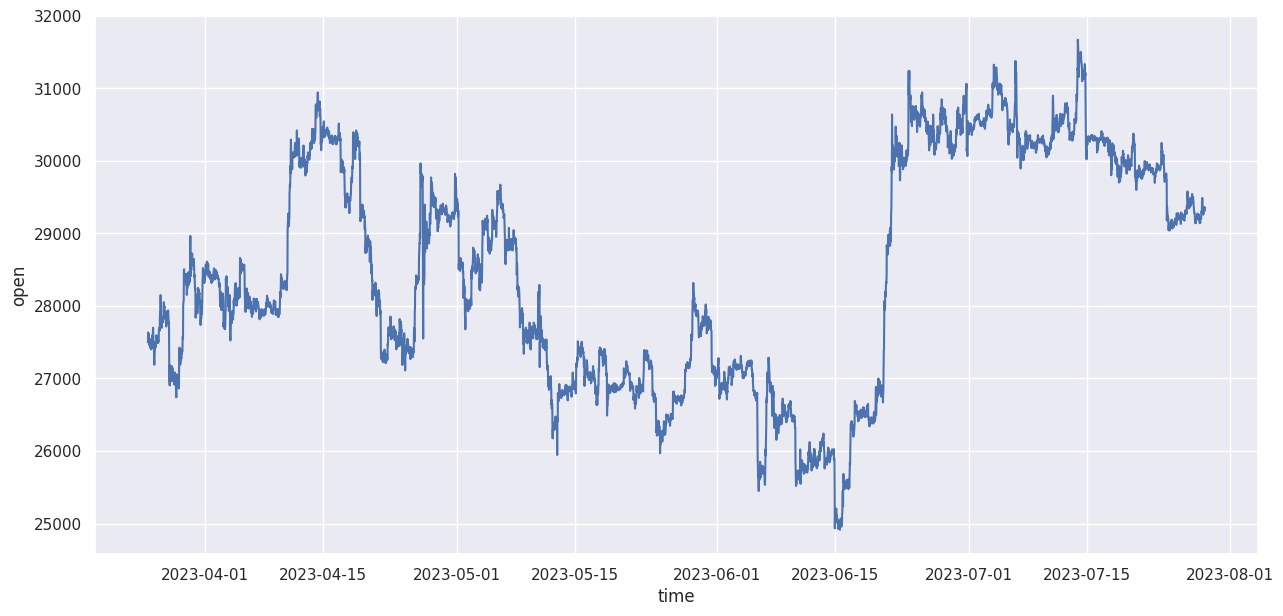

In [156]:
plt.figure(figsize=(15, 7))
sns.lineplot(data=df30,x='time',y='open')

<Axes: xlabel='time', ylabel='open'>

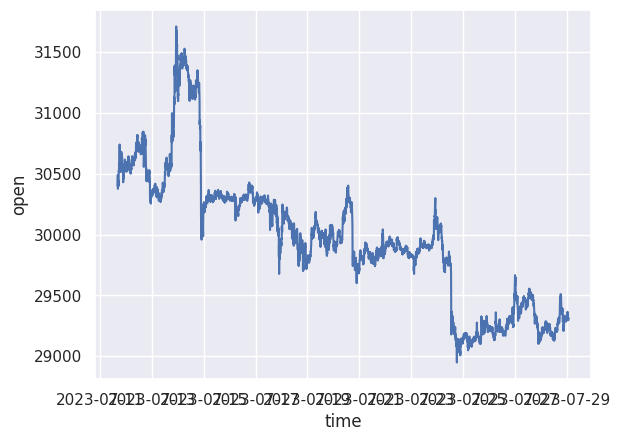

In [157]:
sns.lineplot(data=df5,x='time',y='open')

In [158]:
def check_model_full(model, X, y,df):
    model.fit(X, y)
    y_pred_1 = model.predict(X)
    print(f'r2 {r2_score(y,y_pred_1)}, absolute {mean_absolute_error(y,y_pred_1)}')
    sns.lineplot(data=df[len(df)-len(y):],x='time',y='open')
    sns.lineplot(x=df[len(df)-len(y):].time,y=y_pred_1,c='red')

r2 0.657900252483573, absolute 726.5029907226562


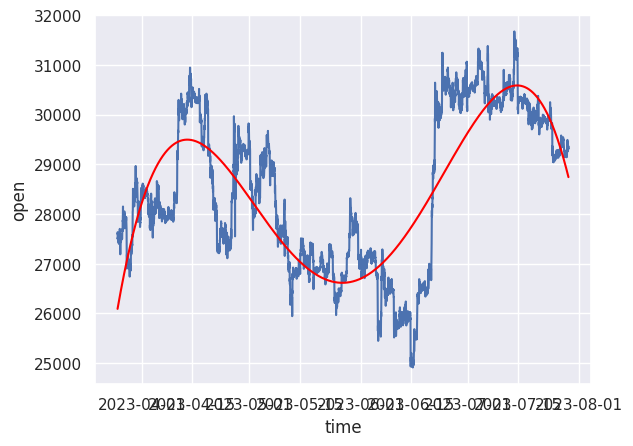

In [159]:
df30['trend_2']=df30.trend**2
df30['trend_3']=df30.trend**3
df30['trend_4']=df30.trend**4
X_time_trend=df30[['trend','trend_2','trend_3','trend_4']]
y=df30['open']
lin_model = Ridge(max_iter=5000)
lin_model.fit(X_time_trend,y)
linear = pd.Series(lin_model.predict(X_time_trend),index=y.index)
check_model_full(Ridge(max_iter=5000), X_time_trend, y,df30)

r2 0.8592177916956145, absolute 410.07759216664505


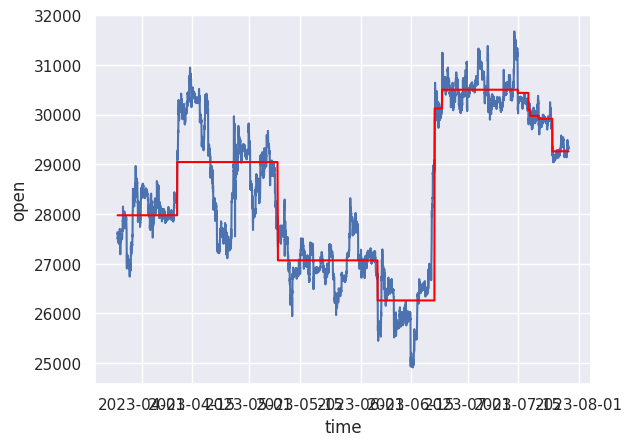

In [160]:
tree_model = RandomForestRegressor(n_estimators=5,max_depth=5)
tree_model.fit(X_time_trend,y)
tree = pd.Series(tree_model.predict(X_time_trend),index=y.index)
check_model_full(RandomForestRegressor(n_estimators=5,max_depth=3), X_time_trend, y,df30)

In [161]:
day_mean = y.rolling(window=48).mean()
day_var = y.rolling(window=48).std()
week_mean = y.rolling(window=48*7).mean()
week_var = y.rolling(window=48*7).std()

In [162]:
time = np.arange(len(y))
freq=365.25*24
order=4
k =  2 * np.pi * (1 / freq) * time
for i in range(1,order+1):
    df30[f'sin_{i}'] = np.sin(i*k)
    df30[f'cos_{i}'] = np.cos(i*k)


In [163]:
X_fourier = df30[['sin_1','cos_1','sin_2','cos_2','sin_3','cos_3','sin_4','cos_4']]

<Axes: xlabel='open_time'>

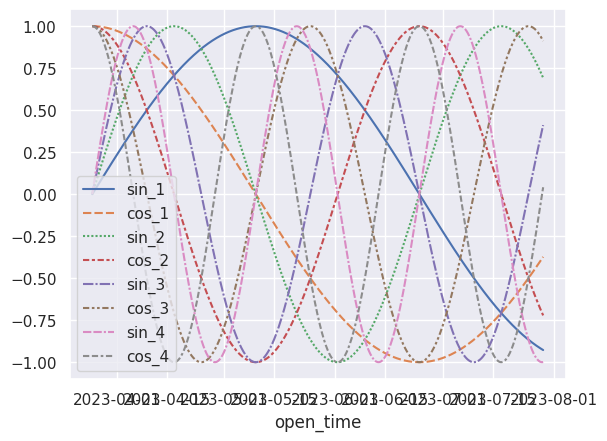

In [164]:
sns.lineplot(X_fourier)

r2 0.7613102778755831, absolute 617.7910573716284


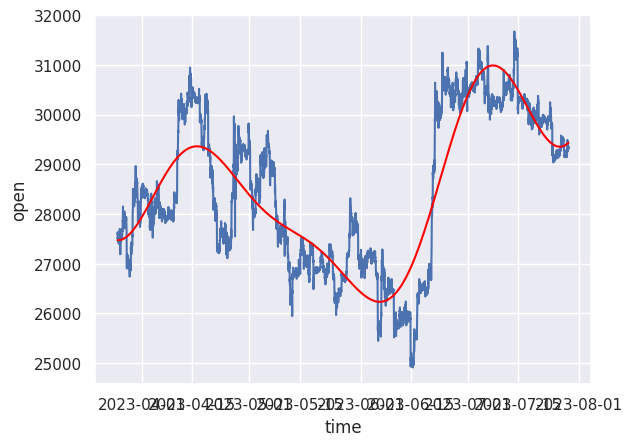

In [165]:
season_model = Lasso()
season_model.fit(X_fourier,y)
seasonal = pd.Series(season_model.predict(X_fourier),index=y.index)
check_model_full(Lasso(),X_fourier,y,df30)

# inserting global features into local dataset

In [166]:
df5.columns

Index(['open', 'high', 'low', 'close', 'volume', 'q_vol', 'trades',
       'taker_buy_volume', 'taker_q_volume', 'ignored', 'trend', 'time'],
      dtype='object')

In [167]:
df5 = df5.drop(['high','low','close','volume','q_vol','trades','taker_buy_volume',
                'taker_q_volume','ignored','trend','time'],axis=1)

In [168]:
features = [linear,tree,seasonal,day_mean,day_var,week_mean,week_var]
def global_into_local(df5,features):
    local_features = []
    n=len(features)
    for i in range(n):
        local_features.append(pd.Series(index=df5.index))
    for i in df5.index:
        if i.minute>=30:
            for j in range(n):
                local_features[j][i] = features[j][i.replace(minute=30)]
        else:
            for j in range(n):
                local_features[j][i] = features[j][i.replace(minute=0)]
    df5['linear'] = local_features[0]
    df5['tree'] = local_features[0]
    df5['seasonal'] = local_features[0]
    df5['day_mean'] = local_features[0]
    df5['day_var'] = local_features[0]
    df5['week_mean'] = local_features[0]
    df5['week_var'] = local_features[0]
            

In [169]:
global_into_local(df5,features)

In [170]:
X=df5

In [171]:
dayofmonth = pd.Series(map(lambda x: x.date().day, X.index), index=X.index)
dayofweek = pd.Series(map(lambda x: x.date().weekday(), X.index), index=X.index)
hourofday = pd.Series(map(lambda x: x.time().hour, X.index), index=X.index)

In [172]:
X['day_of_month'] = dayofmonth
X['day_of_week'] = dayofweek
X['hour_of_day'] = hourofday
X['const'] = np.ones(len(X))
X['time'] = np.arange(1,len(X)+1)

In [173]:
def add_lags(X,count=72):
    for i in range(1,count+1):
        X[f'lag_{i}'] = X.open.shift(i)

In [174]:
add_lags(X)
X

,open,linear,tree,seasonal,day_mean,day_var,week_mean,week_var,day_of_month,day_of_week,...,lag_63,lag_64,lag_65,lag_66,lag_67,lag_68,lag_69,lag_70,lag_71,lag_72
open_time,,,,,,,,,,,,,,,,,,,,,
2023-07-11 16:25:00,30401.400391,30524.701172,30524.701172,30524.701172,30524.701172,30524.701172,30524.701172,30524.701172,11,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-07-11 16:30:00,30408.000000,30525.494141,30525.494141,30525.494141,30525.494141,30525.494141,30525.494141,30525.494141,11,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-07-11 16:35:00,30472.789062,30525.494141,30525.494141,30525.494141,30525.494141,30525.494141,30525.494141,30525.494141,11,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-07-11 16:40:00,30489.849609,30525.494141,30525.494141,30525.494141,30525.494141,30525.494141,30525.494141,30525.494141,11,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-07-11 16:45:00,30375.779297,30525.494141,30525.494141,30525.494141,30525.494141,30525.494141,30525.494141,30525.494141,11,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-29 01:00:00,29313.769531,28741.527344,28741.527344,28741.527344,28741.527344,28741.527344,28741.527344,28741.527344,29,5,...,29394.000000,29389.929688,29370.000000,29377.259766,29360.310547,29371.089844,29343.310547,29345.140625,29351.080078,29387.990234
2023-07-29 01:05:00,29307.990234,28741.527344,28741.527344,28741.527344,28741.527344,28741.527344,28741.527344,28741.527344,29,5,...,29376.369141,29394.000000,29389.929688,29370.000000,29377.259766,29360.310547,29371.089844,29343.310547,29345.140625,29351.080078
2023-07-29 01:10:00,29308.000000,28741.527344,28741.527344,28741.527344,28741.527344,28741.527344,28741.527344,28741.527344,29,5,...,29376.630859,29376.369141,29394.000000,29389.929688,29370.000000,29377.259766,29360.310547,29371.089844,29343.310547,29345.140625


In [175]:
X.columns

Index(['open', 'linear', 'tree', 'seasonal', 'day_mean', 'day_var',
       'week_mean', 'week_var', 'day_of_month', 'day_of_week', 'hour_of_day',
       'const', 'time', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6',
       'lag_7', 'lag_8', 'lag_9', 'lag_10', 'lag_11', 'lag_12', 'lag_13',
       'lag_14', 'lag_15', 'lag_16', 'lag_17', 'lag_18', 'lag_19', 'lag_20',
       'lag_21', 'lag_22', 'lag_23', 'lag_24', 'lag_25', 'lag_26', 'lag_27',
       'lag_28', 'lag_29', 'lag_30', 'lag_31', 'lag_32', 'lag_33', 'lag_34',
       'lag_35', 'lag_36', 'lag_37', 'lag_38', 'lag_39', 'lag_40', 'lag_41',
       'lag_42', 'lag_43', 'lag_44', 'lag_45', 'lag_46', 'lag_47', 'lag_48',
       'lag_49', 'lag_50', 'lag_51', 'lag_52', 'lag_53', 'lag_54', 'lag_55',
       'lag_56', 'lag_57', 'lag_58', 'lag_59', 'lag_60', 'lag_61', 'lag_62',
       'lag_63', 'lag_64', 'lag_65', 'lag_66', 'lag_67', 'lag_68', 'lag_69',
       'lag_70', 'lag_71', 'lag_72'],
      dtype='object')

In [176]:
X=X.dropna()
y=X.open
X=X.drop('open',axis=1)

In [177]:
y

open_time
2023-07-11 22:25:00    30531.300781
2023-07-11 22:30:00    30559.339844
2023-07-11 22:35:00    30537.320312
2023-07-11 22:40:00    30535.830078
2023-07-11 22:45:00    30543.230469
                           ...     
2023-07-29 01:00:00    29313.769531
2023-07-29 01:05:00    29307.990234
2023-07-29 01:10:00    29308.000000
2023-07-29 01:15:00    29314.490234
2023-07-29 01:20:00    29296.160156
Name: open, Length: 4932, dtype: float32

In [245]:
def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """

    # get the index after which test set starts
    test_index = int(len(X) * (1 - test_size))

    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]

    return X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.1)

In [237]:
def check_model_with_CV(model):
    print(f'CHECKING {model}')
    print()
    model.fit(X_train, y_train)

    print('Mean absolute error in train')
    print(mean_absolute_error(model.predict(X_train),y_train))
    print('Mean absolute error in test (1 percent of all data)')
    print(mean_absolute_error(model.predict(X_test),y_test))

    cv = cross_val_score(
                model, X_train, y_train, cv=tscv, scoring="neg_mean_absolute_error"
            )
    print()
    print('CROSS VALIDATION')
    for i in range(len(cv)):
        print(f'mean error in {i+1} split: '+ str(-cv[i]))
    return model

CHECKING LinearRegression()

Mean absolute error in train
18.357177654284406
Mean absolute error in test (1 percent of all data)
13.826650136959957

CROSS VALIDATION
mean error in 1 split: 36.004137143643824
mean error in 2 split: 326926018.4168079
mean error in 3 split: 21.29405174390781
mean error in 4 split: 18.468318432388152
mean error in 5 split: 17.274634523033853


<Axes: xlabel='open_time', ylabel='open'>

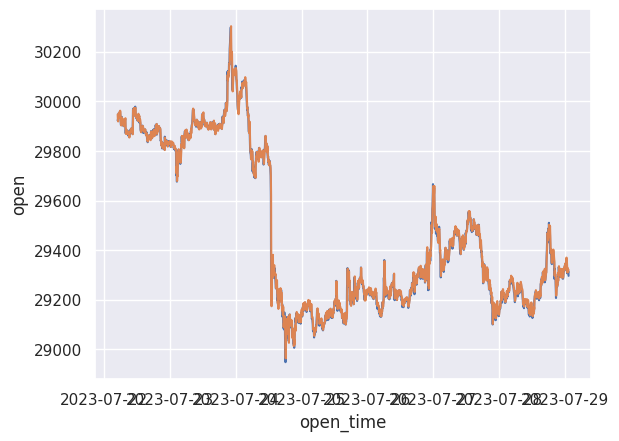

In [238]:
lr = check_model_with_CV(LinearRegression())

sns.lineplot(y_test)
sns.lineplot(pd.Series(lr.predict(X_test), index = y_test.index))

CHECKING RandomForestRegressor(max_depth=10, n_estimators=10)

Mean absolute error in train
11.161033763293869
Mean absolute error in test (1 percent of all data)
313.0941876817383

CROSS VALIDATION
mean error in 1 split: 352.1714049323954
mean error in 2 split: 19.72748203408306
mean error in 3 split: 56.674378796553924
mean error in 4 split: 24.464047064908517
mean error in 5 split: 22.628616607019108


<Axes: xlabel='open_time', ylabel='open'>

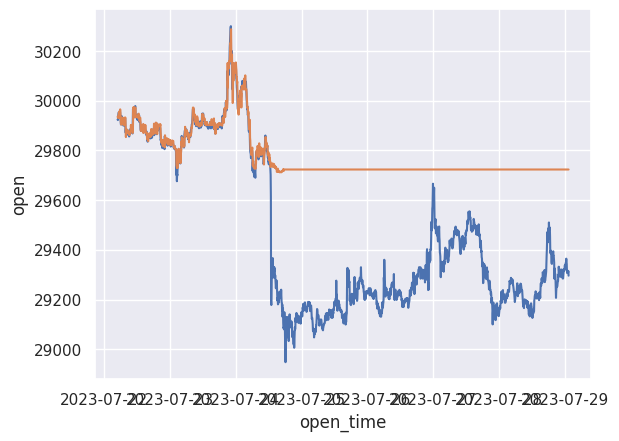

In [239]:
tree = check_model_with_CV(RandomForestRegressor(n_estimators=10,max_depth=10))

sns.lineplot(y_test)
sns.lineplot(pd.Series(tree.predict(X_test), index = y_test.index))

CHECKING Lasso(alpha=5, max_iter=5000)

Mean absolute error in train
18.322648779661595
Mean absolute error in test (1 percent of all data)
13.582869000132183

CROSS VALIDATION
mean error in 1 split: 35.907959283107175
mean error in 2 split: 11.137852110309975
mean error in 3 split: 20.973604727057342
mean error in 4 split: 17.966980280852194
mean error in 5 split: 16.848729083439654


<Axes: xlabel='open_time', ylabel='open'>

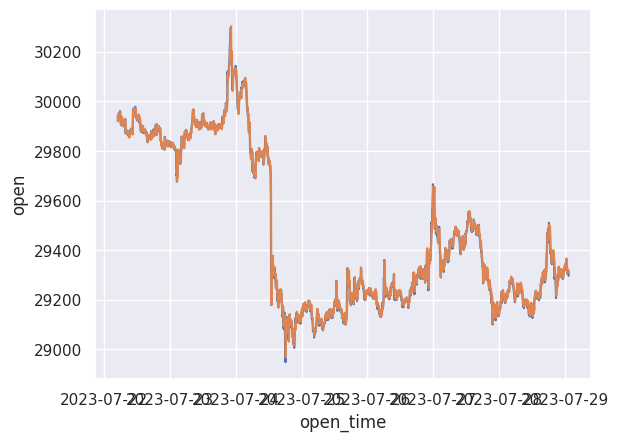

In [240]:
lasso = check_model_with_CV(Lasso(alpha=5,max_iter=5000))

sns.lineplot(y_test)
sns.lineplot(pd.Series(lasso.predict(X_test), index = y_test.index))

CHECKING Ridge(alpha=100, max_iter=5000)

Mean absolute error in train
16.70777475698117
Mean absolute error in test (1 percent of all data)
12.747780097871066

CROSS VALIDATION
mean error in 1 split: 68.84194521129238
mean error in 2 split: 20.115531851548933
mean error in 3 split: 17.80418072120412
mean error in 4 split: 13.417690483822675
mean error in 5 split: 14.095953034146698


<Axes: xlabel='open_time', ylabel='open'>

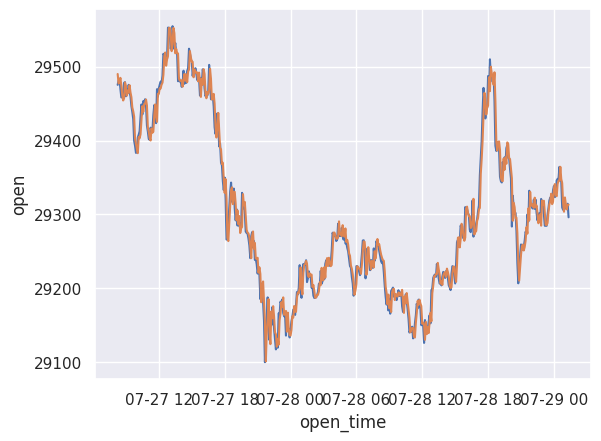

In [249]:
ridge = check_model_with_CV(Ridge(alpha=100,max_iter=5000))

sns.lineplot(y_test)
sns.lineplot(pd.Series(ridge.predict(X_test), index = y_test.index))

CHECKING LinearSVR(dual='auto')

Mean absolute error in train
39.722369004232505
Mean absolute error in test (1 percent of all data)
46.4579587413366

CROSS VALIDATION
mean error in 1 split: 101.28562288286824
mean error in 2 split: 47.47254348325433
mean error in 3 split: 34.43499302155362
mean error in 4 split: 29.964345319433694
mean error in 5 split: 26.623064728065067


<Axes: xlabel='open_time', ylabel='open'>

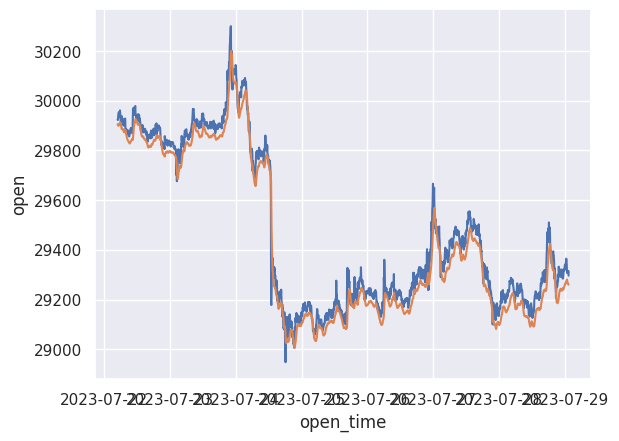

In [242]:
svr = check_model_with_CV(LinearSVR(dual="auto"))

sns.lineplot(y_test)
sns.lineplot(pd.Series(svr.predict(X_test), index = y_test.index))

In [258]:
estimators = [
    ('ridge',Ridge(alpha=50,max_iter=5000)),
    ('lr',LinearRegression())
]
final = LinearRegression()

CHECKING StackingRegressor(estimators=[('ridge', Ridge(alpha=50, max_iter=5000)),
                              ('lr', LinearRegression())],
                  final_estimator=LinearRegression())

Mean absolute error in train
16.78749985363603
Mean absolute error in test (1 percent of all data)
12.720861287355918

CROSS VALIDATION
mean error in 1 split: 218775370.09831208
mean error in 2 split: 20.112936574598418
mean error in 3 split: 18.403153623616344
mean error in 4 split: 13.41171600681259
mean error in 5 split: 14.278825099657741


<Axes: xlabel='open_time', ylabel='open'>

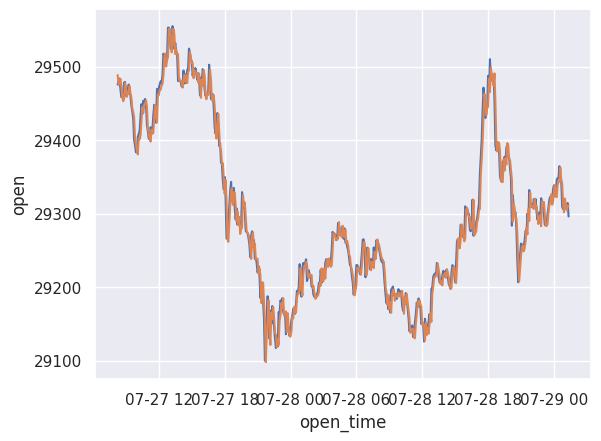

In [259]:
stack = check_model_with_CV(StackingRegressor(estimators,final))

sns.lineplot(y_test)
sns.lineplot(pd.Series(stack.predict(X_test), index = y_test.index))

In [257]:
mean_absolute_error(y_train,1/2.0*(ridge.predict(X_train)+lr.predict(X_train)))

16.75710274833251

In [260]:
def day_str(day):
    if day<=9:
        return '0'+str(day)
    return str(day)
def month_profit(model_fitted, month,start):
    total_profit = 0
    for day in range(15,30):
        sum_day = 0
        y_day = y[(y.index >= f"{month}-{day_str(day)} 00:00:00") & (y.index <= f"{month}-{day_str(day+1)} 00:00:00")]
        X_day = X[(X.index >= f"{month}-{day_str(day)} 00:00:00") & (X.index <= f"{month}-{day_str(day+1)} 00:00:00")]
        if len(y_day)>0:
            y_pred = model_fitted.predict(X_day)
        for i in range(1, len(y_day)):
            #if True:
            if y_pred[i]-y_day[i-1]>0:
                sum_day += ((start)*(y_day[i]/y_day[i-1]-1))
                start+=((start)*(y_day[i]/y_day[i-1]-1))
            if y_pred[i]-y_day[i-1]<=0:
                #pass
                sum_day += -((start)*(y_day[i]/y_day[i-1]-1))
                start+=-((start)*(y_day[i]/y_day[i-1]-1))
        print(f'Profit for day {day} is {sum_day}. Current money: {start}')
        total_profit += sum_day
    print()
    print()
    return start

In [266]:
month='2023-07'
print(f'Total profit for {month} is {month_profit(stack,month,100)-100}')

Profit for day 15 is 0.18364459364436728. Current money: 100.18364459364446
Profit for day 16 is 1.2599810809382632. Current money: 101.44362567458262
Profit for day 17 is 3.620384015822482. Current money: 105.06400969040521
Profit for day 18 is 3.6604515207109727. Current money: 108.72446121111619
Profit for day 19 is 0.7689433743691048. Current money: 109.4934045854854
Profit for day 20 is 3.387582214371324. Current money: 112.88098679985673
Profit for day 21 is 4.123328764075655. Current money: 117.00431556393241
Profit for day 22 is -0.384856001004587. Current money: 116.61945956292782
Profit for day 23 is 0.05888820687098632. Current money: 116.67834776979878
Profit for day 24 is 3.676596572340641. Current money: 120.35494434213929
Profit for day 25 is -0.3300931338383299. Current money: 120.02485120830093
Profit for day 26 is 0.8652929562310899. Current money: 120.89014416453207
Profit for day 27 is 3.1251499400804486. Current money: 124.01529410461255
Profit for day 28 is 1.1309

In [146]:
mod = ElasticNet(max_iter=5000)
mod.fit(X,y)

ElasticNet(max_iter=5000)

<Axes: >

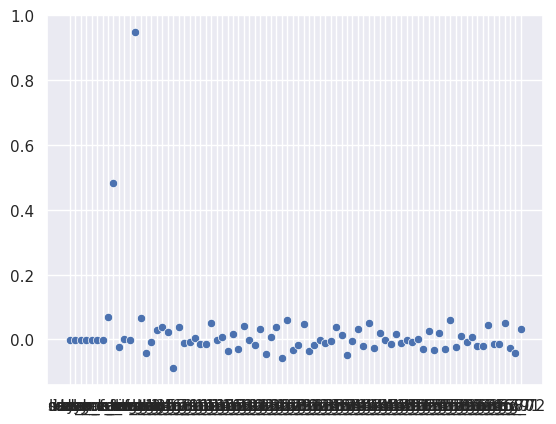

In [268]:
sns.scatterplot(x=X.columns,y=ridge.coef_)

In [267]:
ridge.coef_

array([-2.60084167e-04, -2.60083284e-04, -2.60083591e-04, -2.60083720e-04,
       -2.60083991e-04, -2.60083991e-04, -2.60083991e-04,  6.91949086e-02,
        4.82829018e-01, -2.17954019e-02,  0.00000000e+00, -2.90377613e-03,
        9.48410098e-01,  6.59014936e-02, -4.06293840e-02, -9.08020503e-03,
        2.87388691e-02,  3.96808289e-02,  2.35129642e-02, -8.73048379e-02,
        3.80873106e-02, -1.13846066e-02, -8.19337997e-03,  6.05984049e-03,
       -1.27197104e-02, -1.40163025e-02,  4.97945837e-02, -2.85527870e-03,
        6.97264521e-03, -3.58197464e-02,  1.74618866e-02, -2.98223378e-02,
        4.01344248e-02, -3.03692006e-03, -1.60209278e-02,  3.34971391e-02,
       -4.53841255e-02,  8.20357444e-03,  3.89146312e-02, -5.74946406e-02,
        6.09245596e-02, -3.31607971e-02, -1.61506736e-02,  4.77743696e-02,
       -3.51046458e-02, -1.77343793e-02, -1.53458432e-03, -9.84892937e-03,
       -5.85988811e-03,  3.94575411e-02,  1.27962240e-02, -4.64348728e-02,
       -5.15545604e-03,  

In [87]:
X_train.columns

Index(['linear', 'tree', 'seasonal', 'day_mean', 'day_var', 'week_mean',
       'week_var', 'day_of_month', 'day_of_week', 'hour_of_day', 'lag_1',
       'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8', 'lag_9',
       'lag_10', 'lag_11', 'lag_12', 'lag_13', 'lag_14', 'lag_15', 'lag_16',
       'lag_17', 'lag_18', 'lag_19', 'lag_20', 'lag_21', 'lag_22', 'lag_23',
       'lag_24', 'lag_25', 'lag_26', 'lag_27', 'lag_28', 'lag_29', 'lag_30',
       'lag_31', 'lag_32', 'lag_33', 'lag_34', 'lag_35', 'lag_36', 'lag_37',
       'lag_38', 'lag_39', 'lag_40', 'lag_41', 'lag_42', 'lag_43', 'lag_44',
       'lag_45', 'lag_46', 'lag_47', 'lag_48', 'lag_49', 'lag_50', 'lag_51',
       'lag_52', 'lag_53', 'lag_54', 'lag_55', 'lag_56', 'lag_57', 'lag_58',
       'lag_59', 'lag_60', 'lag_61', 'lag_62', 'lag_63', 'lag_64', 'lag_65',
       'lag_66', 'lag_67', 'lag_68', 'lag_69', 'lag_70', 'lag_71', 'lag_72'],
      dtype='object')

In [103]:
len(X_train.columns)

82

In [104]:
len(mod.coef_)

82

In [121]:
lr

LinearRegression()

In [ ]:
# const, time, trigonometric